## Atividade 02 - B

b) Considerando o conjunto de dados Credit Approval Data Set,
6. Explore visualmente e numericamente os dados.
7. Prepare os conjunto de dados utilizando as técnicas ensinadas na disciplina, quando
pertinente.
8. Para cada técnica de preparação de dados aplicada, avalie os algorimos K-NN,
LogisticRegression, SVM, Árvore de descisão, RandomForest e um outro algoritmo que
deverá ser escolhido pelo aluno.
9. Utilize gráficos e tabelas para apresentar as métricas obtidas (em treino e em teste), e
escolha o melhor modelo com base em uma das métricas apresentadas. Justifique a escolha
da métrica com base no sistema em questão.
10. Envie a URL do jupyter notebook no GitHub.

## Identificação do problema
"Este dataset trata-se de aplicaçãoes para liberação de cartão de crédito, baseado em algumas características de consumo, emprego e renda de alguns clientes."

Decidir se o cliente deve ou não receber um cartao de crédito através de seu "histórico".


### Setup do Projeto

In [1]:
# Importação das bibliotecas e identificação do endereço de download do dataset

# Para Git:
import joblib
import os
import urllib

# Bibliotecas:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,  classification_report

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#-------------------------------------------------------------------------------
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#-------------------------------------------------------------------------------

print(f'Matplot version: {matplotlib.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Seaborn version: {sns.__version__}')

CREDIT_ROOT = 'http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/'
CREDIT_URL = CREDIT_ROOT + 'crx.data' 

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'crx.csv'
CREDIT_DATA = os.path.join(DATA_PATH, DATA_FILE)

RANDOM_STATE = 42

print('\nConfiguração completa !')

Matplot version: 3.2.2
Numpy version: 1.19.5
Pandas version: 1.1.5
Scikit-learn version: 0.22.2.post1
Seaborn version: 0.11.2

Configuração completa !


### Download e Carregamento dos Dados

In [2]:
# Download do dataset e carregamento do mesmo para um DataFrame.

def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)
    
download_data(CREDIT_URL, DATA_PATH, DATA_FILE)

col_names = ['gender', 'age', 'debt', 'married', 'bank_customer', 'education_level', 'ethnicity', 'years_employed',
             'prior_default', 'employed', 'credit_score', 'drivers_license', 'citizen', 'zip_code', 'income', 'approved']

def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=col_names)

credit_df = load_data(DATA_PATH, DATA_FILE)

### Análise Exploratória dos Dados

In [3]:
credit_df

,gender,age,debt,married,bank_customer,education_level,ethnicity,years_employed,prior_default,employed,credit_score,drivers_license,citizen,zip_code,income,approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


In [4]:
credit_df.describe()

## Os dados das features possuem valores com amplitudes muito distantes entre si. Dessa forma, os mesmos deverão ser normalizados.

,debt,years_employed,credit_score,income
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [5]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           690 non-null    object 
 1   age              690 non-null    object 
 2   debt             690 non-null    float64
 3   married          690 non-null    object 
 4   bank_customer    690 non-null    object 
 5   education_level  690 non-null    object 
 6   ethnicity        690 non-null    object 
 7   years_employed   690 non-null    float64
 8   prior_default    690 non-null    object 
 9   employed         690 non-null    object 
 10  credit_score     690 non-null    int64  
 11  drivers_license  690 non-null    object 
 12  citizen          690 non-null    object 
 13  zip_code         690 non-null    object 
 14  income           690 non-null    int64  
 15  approved         690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [6]:
ausentes = (credit_df[credit_df.columns] == '?').sum()
print(ausentes)

#Dataframe possui dados ausentes.

gender             12
age                12
debt                0
married             6
bank_customer       6
education_level     9
ethnicity           9
years_employed      0
prior_default       0
employed            0
credit_score        0
drivers_license     0
citizen             0
zip_code           13
income              0
approved            0
dtype: int64


In [7]:
credit_df['age']=credit_df['age'].replace('?', np.nan)


In [8]:
credit_df['age'] = credit_df['age'].astype(float)
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           690 non-null    object 
 1   age              678 non-null    float64
 2   debt             690 non-null    float64
 3   married          690 non-null    object 
 4   bank_customer    690 non-null    object 
 5   education_level  690 non-null    object 
 6   ethnicity        690 non-null    object 
 7   years_employed   690 non-null    float64
 8   prior_default    690 non-null    object 
 9   employed         690 non-null    object 
 10  credit_score     690 non-null    int64  
 11  drivers_license  690 non-null    object 
 12  citizen          690 non-null    object 
 13  zip_code         690 non-null    object 
 14  income           690 non-null    int64  
 15  approved         690 non-null    object 
dtypes: float64(3), int64(2), object(11)
memory usage: 86.4+ KB


In [9]:
credit_df['approved'].value_counts()

-    383
+    307
Name: approved, dtype: int64

In [10]:
credit_df['gender'].value_counts()

b    468
a    210
?     12
Name: gender, dtype: int64

In [11]:
credit_df['gender'].unique()

array(['b', 'a', '?'], dtype=object)

In [12]:
credit_df['bank_customer'].value_counts()

g     519
p     163
?       6
gg      2
Name: bank_customer, dtype: int64

In [13]:
#Transformacao das features categoricas para numericas para aplicacao no algoritmo

le = LabelEncoder()

for column in credit_df.columns:
    if credit_df[column].dtype == 'object':
        credit_df[column] = le.fit_transform(credit_df[column])
        
credit_df

,gender,age,debt,married,bank_customer,education_level,ethnicity,years_employed,prior_default,employed,credit_score,drivers_license,citizen,zip_code,income,approved
0,2,30.83,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,0
1,1,58.67,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,0
2,1,24.50,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,0
3,2,27.83,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,0
4,2,20.17,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,2,21.08,10.085,3,3,5,4,1.25,0,0,0,0,0,90,0,1
686,1,22.67,0.750,2,1,2,8,2.00,0,1,2,1,0,67,394,1
687,1,25.25,13.500,3,3,6,3,2.00,0,1,1,1,0,67,1,1
688,2,17.92,0.205,2,1,1,8,0.04,0,0,0,0,0,96,750,1


In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
credit_df[['gender','age', 'married', 'bank_customer', 'education_level', 'ethnicity','zip_code']] = imputer.fit_transform(credit_df[['gender', 'age',
        'married', 'bank_customer', 'education_level', 'ethnicity','zip_code']].values)

credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           690 non-null    float64
 1   age              690 non-null    float64
 2   debt             690 non-null    float64
 3   married          690 non-null    float64
 4   bank_customer    690 non-null    float64
 5   education_level  690 non-null    float64
 6   ethnicity        690 non-null    float64
 7   years_employed   690 non-null    float64
 8   prior_default    690 non-null    int64  
 9   employed         690 non-null    int64  
 10  credit_score     690 non-null    int64  
 11  drivers_license  690 non-null    int64  
 12  citizen          690 non-null    int64  
 13  zip_code         690 non-null    float64
 14  income           690 non-null    int64  
 15  approved         690 non-null    int64  
dtypes: float64(9), int64(7)
memory usage: 86.4 KB


In [15]:
# Normalização

X = credit_df.drop(['approved'], axis=1)
y = credit_df['approved']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

X_scaled

,gender,age,debt,married,bank_customer,education_level,ethnicity,years_employed,prior_default,employed,credit_score,drivers_license,citizen,zip_code,income
0,1.0,0.256842,0.000000,0.666667,0.333333,0.928571,0.888889,0.043860,1.0,1.0,0.014925,0.0,0.0,0.400000,0.00000
1,0.5,0.675489,0.159286,0.666667,0.333333,0.785714,0.444444,0.106667,1.0,1.0,0.089552,0.0,0.0,0.064706,0.00560
2,0.5,0.161654,0.017857,0.666667,0.333333,0.785714,0.444444,0.052632,1.0,0.0,0.000000,0.0,0.0,0.564706,0.00824
3,1.0,0.211729,0.055000,0.666667,0.333333,0.928571,0.888889,0.131579,1.0,1.0,0.074627,1.0,0.0,0.182353,0.00003
4,1.0,0.096541,0.200893,0.666667,0.333333,0.928571,0.888889,0.060000,1.0,0.0,0.000000,0.0,1.0,0.217647,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1.0,0.110226,0.360179,1.000000,1.000000,0.357143,0.444444,0.043860,0.0,0.0,0.000000,0.0,0.0,0.529412,0.00000
686,0.5,0.134135,0.026786,0.666667,0.333333,0.142857,0.888889,0.070175,0.0,1.0,0.029851,1.0,0.0,0.394118,0.00394
687,0.5,0.172932,0.482143,1.000000,1.000000,0.428571,0.333333,0.070175,0.0,1.0,0.014925,1.0,0.0,0.394118,0.00001
688,1.0,0.062707,0.007321,0.666667,0.333333,0.071429,0.888889,0.001404,0.0,0.0,0.000000,0.0,0.0,0.564706,0.00750


### Treinamento

In [16]:
print(f'age:',credit_df['age'].min(),'/', credit_df['age'].max())
print(f'debt:',credit_df['debt'].min(),'/', credit_df['debt'].max())
print(f'years:',credit_df['years_employed'].min(),'/', credit_df['years_employed'].max())
print(f'credit:',credit_df['credit_score'].min(),'/', credit_df['credit_score'].max())
print(f'zip_code:',credit_df['zip_code'].min(),'/', credit_df['zip_code'].max())
print(f'income:',credit_df['income'].min(),'/', credit_df['income'].max())
print(f'approved:',credit_df['approved'].min(),'/', credit_df['approved'].max())

age: 13.75 / 80.25
debt: 0.0 / 28.0
years: 0.0 / 28.5
credit: 0 / 67
zip_code: 0.0 / 170.0
income: 0 / 100000
approved: 0 / 1


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, stratify=y, random_state=RANDOM_STATE)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (483, 15)
y_train shape: (483,)
X_test shape: (207, 15)
y_test shape: (207,)


In [18]:
def build_classifiers():
    """
    Retorna uma lista com os classificadores que serão avaliados.
    """
    classifiers = []
    classifiers.append(
                      ('knn',                              
                        KNeighborsClassifier(),            
                        {'n_neighbors' : range(1, 33, 2)}  
                      )
    )

    classifiers.append(
                      ('lr',                               
                        LogisticRegression(max_iter=1000), 
                        {'penalty' : ['l2'], 'C' : [100, 10, 1, 0.1, 0.01]}  
                      )
    )
    
    classifiers.append(
                      ('svm',
                        SVC(),
                        {'kernel' : ['linear', 'rbf'], 
                         'C' : [2 ** (-5), 1, 2 ** 5, 2 ** 10],
                         'gamma' : [2 ** (-15), 2 ** (-10), 2 ** (-5), 1, 2 ** 5]
                        }
                      )
    )
    
    classifiers.append(
                      ('dt',
                        DecisionTreeClassifier(),
                        {'max_depth' : [2, 4, 6, 8, 10, 12]}
                      )  
    )
    
    classifiers.append(
                      ('rf',
                        RandomForestClassifier(),
                        {'n_estimators' : [10, 50, 100]}
                      ) 
    )
    
    return classifiers

In [19]:
classifiers = build_classifiers()
results = []
names = []

for name, model, parameters in classifiers:
    print(f'Classificador: {name}')
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    gs.fit(X_train, y_train)
    kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv = cross_val_score(gs, X_train, y_train, cv=kf, scoring='accuracy')
    print(f'Media do resultado do treinamento do CV: {cv.mean():.4f}')
    print(f'Desvio padrao das medicoes dos resultados: {cv.std():.4f}')
    print(f'O melhor resultado foi: {gs.best_params_} com score de {gs.best_score_:.4f}')

    results.append(cv)
    names.append(name)
    
    if name == 'knn':
        y_pred_knn = gs.predict(X_test)
        acuracia = gs.score(X_test, y_test)
        print(f'Acuracia do modelo {name}: {acuracia:.3f}')
    elif name == 'lr':
        y_pred_lr = gs.predict(X_test)       
        acuracia = gs.score(X_test, y_test)
        print(f'Acuracia do modelo {name}: {acuracia:.3f}')
    elif name == 'svm':
        y_pred_svm = gs.predict(X_test)
        acuracia = gs.score(X_test, y_test)
        print(f'Acuracia do modelo {name}: {acuracia:.3f}')
    elif name == 'dt':
        y_pred_dt = gs.predict(X_test)
        acuracia = gs.score(X_test, y_test)
        print(f'Acuracia do modelo {name}: {acuracia:.3f}')
    elif name == 'rf':
        y_pred_rf = gs.predict(X_test)        
        acuracia = gs.score(X_test, y_test)
        print(f'Acuracia do modelo {name}: {acuracia:.3f}')

Classificador: knn
Media do resultado do treinamento do CV: 0.8736
Desvio padrao das medicoes dos resultados: 0.0319
O melhor resultado foi: {'n_neighbors': 3} com score de 0.8903
Acuracia do modelo knn: 0.845
Classificador: lr
Media do resultado do treinamento do CV: 0.8819
Desvio padrao das medicoes dos resultados: 0.0429
O melhor resultado foi: {'C': 10, 'penalty': 'l2'} com score de 0.8800
Acuracia do modelo lr: 0.826
Classificador: svm
Media do resultado do treinamento do CV: 0.9005
Desvio padrao das medicoes dos resultados: 0.0278
O melhor resultado foi: {'C': 1, 'gamma': 1, 'kernel': 'rbf'} com score de 0.8945
Acuracia do modelo svm: 0.831
Classificador: dt
Media do resultado do treinamento do CV: 0.8611
Desvio padrao das medicoes dos resultados: 0.0537
O melhor resultado foi: {'max_depth': 4} com score de 0.8840
Acuracia do modelo dt: 0.802
Classificador: rf
Media do resultado do treinamento do CV: 0.8881
Desvio padrao das medicoes dos resultados: 0.0271
O melhor resultado foi:

In [20]:
print(f'Knn:\n',classification_report(y_test, y_pred_knn))
print(f'LR:\n',classification_report(y_test, y_pred_lr))
print(f'SVM:\n',classification_report(y_test, y_pred_svm))
print(f'DT\n',classification_report(y_test, y_pred_dt))
print(f'RF\n',classification_report(y_test, y_pred_rf))

Knn:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83        92
           1       0.87      0.85      0.86       115

    accuracy                           0.85       207
   macro avg       0.84      0.84      0.84       207
weighted avg       0.85      0.85      0.85       207

LR:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81        92
           1       0.88      0.80      0.84       115

    accuracy                           0.83       207
   macro avg       0.83      0.83      0.83       207
weighted avg       0.83      0.83      0.83       207

SVM:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82        92
           1       0.88      0.81      0.84       115

    accuracy                           0.83       207
   macro avg       0.83      0.83      0.83       207
weighted avg       0.84      0.83      0.83       207

DT

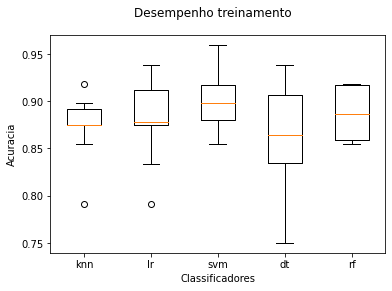

In [22]:
#boxplot
fig, ax = plt.subplots()
fig.suptitle('Desempenho treinamento')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acuracia')
plt.show()

É possível observar que, assim como na primeira atividade, o Random Florest apresentou resultados melhores nos testes, de precisão e acuracia.